In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten
from keras.callbacks import EarlyStopping

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Set the path to your data directory
data_directory = '/content/drive/My Drive/data'
# Function to calculate SDNN from heart rate data
def calculate_sdnn(heart_rate_values, window_size=5):
    # Convert heart rate to RR intervals (assuming constant heart rate for simplicity)
    rr_intervals = 60 / heart_rate_values  # since values are in bpm

    # Calculate SDNN over a moving window
    sdnn_values = []
    for i in range(len(rr_intervals) - window_size + 1):
        sdnn_values.append(np.std(rr_intervals[i:i+window_size]))

    return np.array(sdnn_values)

# Modified function to load and preprocess heart rate data
def load_and_preprocess_heartrate(subject_id):
    file_path = os.path.join(data_directory, 'heart_rate', f'{subject_id}_heartrate.txt')
    data = pd.read_csv(file_path, header=None, names=['date', 'heartrate'])
    heartrate_values = data['heartrate']

    # Calculate SDNN from heart rate data
    sdnn_values = calculate_sdnn(heartrate_values)

    return sdnn_values

def load_labeled_sleep(subject_id):
    file_path = os.path.join(data_directory, 'labels', f'{subject_id}_labeled_sleep.txt')
    data = pd.read_csv(file_path, header=None, delim_whitespace=True, names=['date', 'stage'])
    # Encode sleep labels as binary values: 1 for awake (label=0), 0 for asleep (labels 1-5)
    return (data['stage'] == 0).astype(int).values

subject_ids = [file.split('_')[0] for file in os.listdir(os.path.join(data_directory, 'labels')) if '_labeled_sleep.txt' in file]

X_heartrate = []
y_sleep = []

sequence_length = 50

for subject_id in subject_ids:
    heartrate_values = load_and_preprocess_heartrate(subject_id)
    sleep_labels = load_labeled_sleep(subject_id)

    for i in range(0, len(heartrate_values) - sequence_length):
        X_heartrate.append(heartrate_values[i:i+sequence_length])
        y_sleep.append(sleep_labels[min(i+sequence_length-1, len(sleep_labels)-1)])

In [5]:
import numpy as np
import pandas as pd
import os

# Count the occurrences of each class in y_sleep
class_counts = pd.Series(y_sleep).value_counts()

# Print the class counts
print("Class Counts:")
print(class_counts)

# Calculate the percentage of each class in the dataset
class_percentages = class_counts / len(y_sleep) * 100

# Print the class percentages
print("\nClass Percentages:")
print(class_percentages)


Class Counts:
0    193140
1     59611
dtype: int64

Class Percentages:
0    76.415128
1    23.584872
dtype: float64


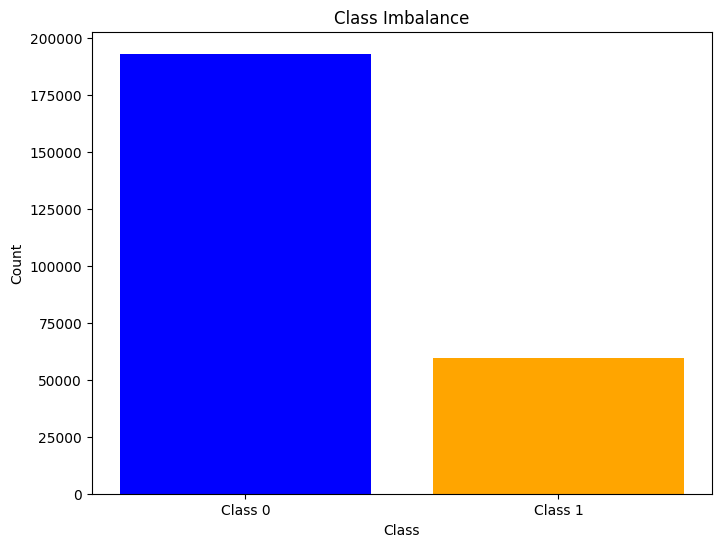

In [6]:
import matplotlib.pyplot as plt

# Class labels and counts
class_labels = ['Class 0', 'Class 1']
class_counts = [193140, 59611]

# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(class_labels, class_counts, color=['blue', 'orange'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Imbalance')
plt.show()


In [ ]:
X_heartrate = np.array(X_heartrate)
y_sleep = np.array(y_sleep)

label_encoder = LabelEncoder()
y_sleep = label_encoder.fit_transform(y_sleep)

scaler = StandardScaler()
X_heartrate_scaled = scaler.fit_transform(X_heartrate)

X_train, X_test, y_train, y_test = train_test_split(
    X_heartrate_scaled, y_sleep, test_size=0.1, random_state=42
)


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize SVM classifier
svm = SVC(kernel='linear')

# Train the model
svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)